In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce RTX 4070 Laptop GPU


device(type='cuda', index=0)

In [37]:
import math
import matplotlib.pyplot as plt
degree = 9 # Polynomial degree same as course demo
weights = torch.randn(degree + 1, requires_grad=True, dtype=torch.float32)  # random initialization for weights
learning_rate = 0.01
lambda_reg = 0.01

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000]) tensor([ 0.1549,  0.7441,  0.8630,  0.9346,  0.0895, -0.3592, -0.8358, -1.0182,
        -0.5562,  0.0181])


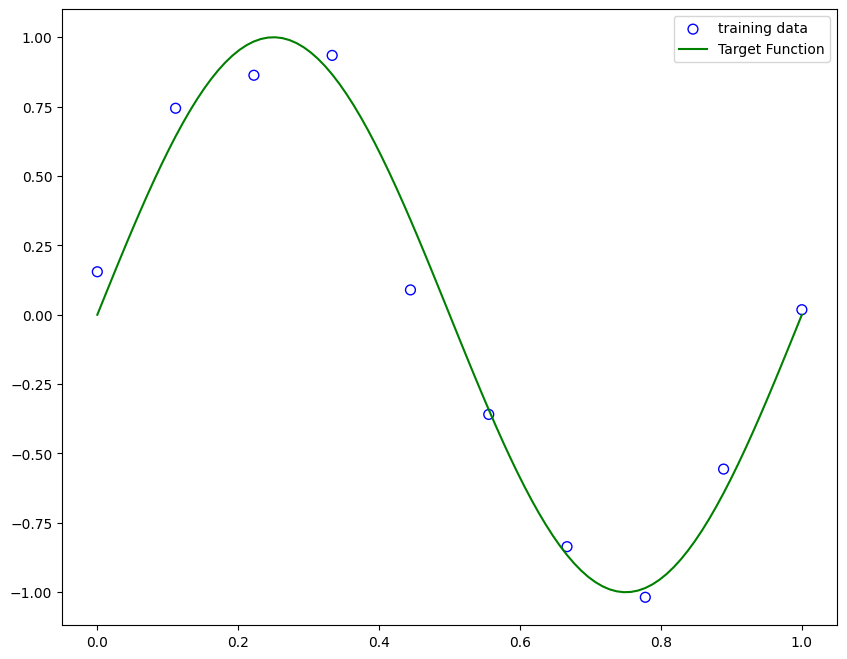

In [38]:

##rewrite datagen using torch api

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    y = func(x) + torch.normal(mean=torch.zeros(x.shape[0]),std=std)
    return x, y

def sinusoidal(x):
    return torch.sin(2 * math.pi * x)



x_train, y_train = create_toy_data(sinusoidal, 10, 0.15)
x_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(x_test)
print(x_train,y_train)



plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

In [39]:
def polynomial_features(x, degree):
    # Create a tensor with columns [1, x, x^2, ..., x^d]
    return torch.stack([x**i for i in range(degree + 1)], dim=1)

def model(x, weights):
    return  polynomial_features(x, degree) @ weights

def loss(predictions, targets, weights, lambda_reg):
    mse_loss = ((predictions - targets) ** 2).mean()  # Mean Squared Error
    l2_reg = lambda_reg * (weights[1:] ** 2).sum()  # L2 regularization skipping weights[0])
    return mse_loss + l2_reg

def gen_gradients(x, y, weights, lambda_reg):
    predictions = model(x, weights)
    poly_x = polynomial_features(x, degree)

    grad_mse = (2 / len(x)) * poly_x.T @ (predictions - y)  # gradient of MSE part using chain rule
    ## $\frac{dMSE}{dW}$ = $\frac{dMSE}{d(Pred-y)}$*$\frac{d(Pred-y)}{dW}$ = 1/len(x)*2*poly_x.T @ (predictions - y)

    grad_l2 = 2 * lambda_reg * weights  ## 2*/lambda*weights
    grad_l2[0] = 0  # No regularization on bias term

    # Combine
    gradients = grad_mse + grad_l2

    return gradients





Epoch 0: Loss = 1.184692621231079
Epoch 1000: Loss = 0.2516433894634247
Epoch 2000: Loss = 0.2079969197511673
Epoch 3000: Loss = 0.18836404383182526
Epoch 4000: Loss = 0.17625263333320618
Epoch 5000: Loss = 0.16831885278224945
Epoch 6000: Loss = 0.16306857764720917
Epoch 7000: Loss = 0.1595851629972458
Epoch 8000: Loss = 0.15727080404758453
Epoch 9000: Loss = 0.15573152899742126
Epoch 10000: Loss = 0.15470679104328156
Epoch 11000: Loss = 0.15402407944202423
Epoch 12000: Loss = 0.15356886386871338
Epoch 13000: Loss = 0.15326514840126038
Epoch 14000: Loss = 0.15306246280670166


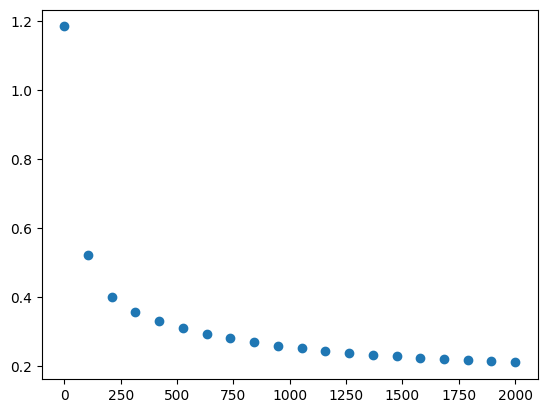

In [40]:
loss_train = []
loss_test = []

for epoch in range(15000):  # Increase the number of epochs for better fitting
    # Compute gradients
    with torch.no_grad():
        gradients = gen_gradients(x_train, y_train, weights,lambda_reg )

    # Update
        weights -= learning_rate * gradients

    # Compute loss for monitoring
        predictions = model(x_train, weights)
        theloss = loss(predictions, y_train, weights, lambda_reg)

    # Print loss for every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss = {theloss.item()}')
    if epoch % 100 == 0 and epoch <2000:
        loss_train.append(theloss.item())


plt.scatter(torch.linspace(0,2000,20),loss_train)##epoch-loss graph
plt.show()

In [41]:
print(torch.linspace(0,1500,15).shape)
print(len(loss_train))

torch.Size([15])
20


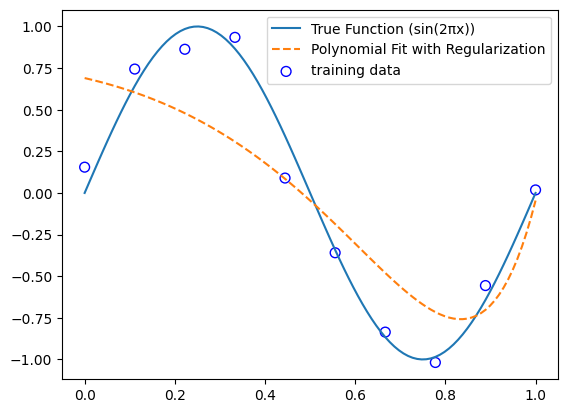

In [42]:
plt.plot(x_test, y_test, label='True Function (sin(2πx))')
plt.plot(x_test, model(x_test, weights).detach(), label='Polynomial Fit with Regularization', linestyle='--')
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.legend()
plt.show()

In [43]:
##Hyperparams:degree = 9 /learning_rate = 0.01/lambda_reg = 0.01

In [45]:
## task2: momentum method
degree = 9 # Polynomial degree same as course demo
weights = torch.randn(degree + 1, requires_grad=True, dtype=torch.float32)  # random initialization for weights
learning_rate = 0.01
lambda_reg = 0.01
eta, beta = 0.6, 0.5


loss_train = []
loss_test = []
velocity = torch.zeros(weights.shape)
for epoch in range(15000):  # Increase the number of epochs for better fitting
    # Compute gradients
    with torch.no_grad():
        gradients = gen_gradients(x_train, y_train, weights,lambda_reg )

        velocity = beta*velocity+gradients
    # Update
        weights -= learning_rate *eta *velocity

    # Compute loss for monitoring
        predictions = model(x_train, weights)
        theloss = loss(predictions, y_train, weights, lambda_reg)

    # Print loss for every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss = {theloss.item()}')
    if epoch % 100 == 0 and epoch <2000:
        loss_train.append(theloss.item())

Epoch 0: Loss = 3.209350824356079
Epoch 1000: Loss = 0.2046724408864975
Epoch 2000: Loss = 0.17599403858184814
Epoch 3000: Loss = 0.16595184803009033
Epoch 4000: Loss = 0.16048669815063477
Epoch 5000: Loss = 0.15730586647987366
Epoch 6000: Loss = 0.15543140470981598
Epoch 7000: Loss = 0.15431983768939972
Epoch 8000: Loss = 0.15365718305110931
Epoch 9000: Loss = 0.15326032042503357
Epoch 10000: Loss = 0.15302163362503052
Epoch 11000: Loss = 0.1528775542974472
Epoch 12000: Loss = 0.15279026329517365
Epoch 13000: Loss = 0.15273724496364594
Epoch 14000: Loss = 0.15270496904850006


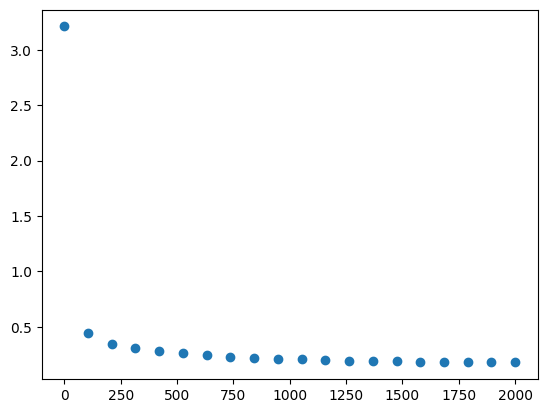

In [46]:
plt.scatter(torch.linspace(0,2000,20),loss_train)##epoch-loss graph
plt.show()

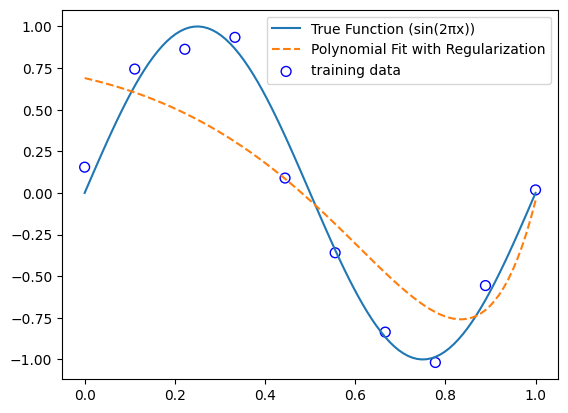

In [47]:
plt.plot(x_test, y_test, label='True Function (sin(2πx))')
plt.plot(x_test, model(x_test, weights).detach(), label='Polynomial Fit with Momentum SGD', linestyle='--')
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.legend()
plt.show()

In [53]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
import pandas as pd
import torch
import gc

D = 2**20
path = 'data/train.csv'
chunk_size = 32

In [54]:
def hash_row(row, D):
    return [abs(hash(f'{col}_{value}')) % D for col, value in zip(row.index, row.values)]


def data(path, D):
    for chunk in pd.read_csv(path, chunksize=32):
        chunk.drop('id',axis =1,inplace=True)
        chunk.drop('hour',axis =1,inplace=True)
        Y= chunk['click']
        chunk.drop('click',axis =1,inplace=True)
        X = chunk.apply(lambda row: hash_row(row, D), axis=1).tolist()  ##one-hot encoding and some hash

        yield X,Y

In [56]:
##device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") ##since we are not using any batch run it on cpu,a little bit faster
gc.collect()
torch.cuda.empty_cache()


In [57]:
# the model

def sigmoid(x):
    x_clamped = torch.clamp(x, min=-35., max=35.)
    return 1/ (1 +torch.exp(-1*x_clamped))##some sigmoid function with boundary


class ClickPredictor(torch.nn.Module):
    def __init__(self, input_dim):
        super(ClickPredictor, self).__init__()
        self.fc = torch.randn(input_dim, 1, device=device, dtype=torch.float32)  # weight
        self.bias = torch.zeros(1, device=device, dtype=torch.float32)           # bias

    def forward(self, x):
        p = sigmoid((x @ self.fc)+self.bias)  # output
        return p

In [58]:
learning_rate = 0.1
model = ClickPredictor(D)

def BCEgradient_no_batch(x,p,y):
    return ((p-y)*x.T).view(-1,1) 


In [59]:
def BCEloss(p,y):
    p = torch.clamp(p, min=10e-15, max=1-10e-15)
    loss = - (y * torch.log(p) + (1 - y) * torch.log(1 - p))  
    return loss 


def BCEgradient(x,p,y):
    return (x.T@(p-y))/10000 
##Not used

In [61]:
File = data(path,D)
with torch.no_grad():
    for epoch in range(20):
        for j in range(3000):##32 per chunk train on 3000 chunks
            File = data('data/train.csv',D)
            a,b = File.__next__()
            X_indice = torch.tensor(a)
            X = torch.zeros(chunk_size,D,device=device)
            X[torch.arange(chunk_size).unsqueeze(1), X_indice] = 1
            X = X.float()
            Y = torch.tensor(b.values,device=device)
            Y = Y.reshape(chunk_size,1).float()
            for i in range(chunk_size):
                p = model.forward(X[i])
                gradient = BCEgradient_no_batch(X[i],p,Y[i])
                tmp = learning_rate*gradient
                model.fc -= tmp
                model.bias = model.bias-(learning_rate*(p-Y[i]))
        print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [80]:
points_precision = []
points_callback = []

In [84]:

for i in range(25): ##draw the curve
    File_test = data('data/train.csv',D)
    threshold = 0.45+0.02*i 
    with torch.no_grad():
        precision = 0
        callback = 0
        TP = 0
        FP = 0
        FN = 0
        for i in range(3000):##skip what we have used in the process of training(first 3000 chunks)
            a,b = File_test.__next__()
        for j in range(320):
            a,b = File_test.__next__()
            X_indice = torch.tensor(a)
            X = torch.zeros(chunk_size,D,device=device)
            X[torch.arange(chunk_size).unsqueeze(1), X_indice] = 1
            X = X.float()
            Y = torch.tensor(b.values,device=device)
            Y = Y.reshape(chunk_size,1).float()
            y_predict = 0
            for i in range(chunk_size):
                p = model.forward(X[i])
                if p > threshold:
                    y_predict = 1
                else:
                    y_predict = 0
                if Y[i] == 1 and y_predict==1:
                    TP = TP+1
                if Y[i] == 0 and y_predict==1:
                    FP = FP+1
                if Y[i] == 1 and y_predict==0:
                    FN = FN +1
        points_precision.append(TP/(TP+FP))
        points_callback.append(TP/(TP+FN))
        print(TP,FP,FN)

768 1721 1010
725 1605 1053
698 1490 1080
663 1369 1115
620 1256 1158
591 1146 1187
556 1050 1222
531 962 1247
493 859 1285
450 777 1328
418 708 1360
404 653 1374
374 595 1404
340 532 1438
310 473 1468
279 421 1499
255 360 1523
225 299 1553
203 254 1575
178 210 1600
151 173 1627
124 133 1654
96 99 1682
72 57 1706
58 39 1720


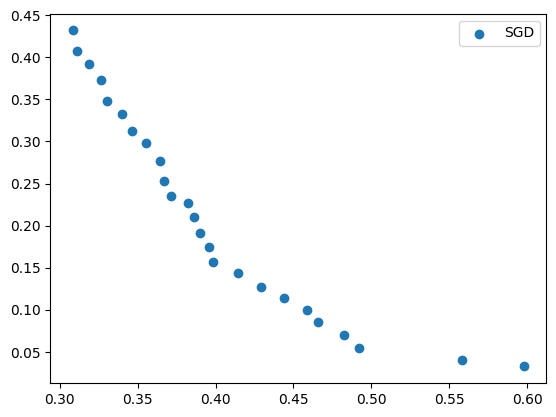

In [93]:
import matplotlib.pyplot as plt
plt.scatter(points_precision, points_callback, label='SGD')
plt.legend()
plt.show()
## The model isn't doing well. I guess more trainning data and more complex model is needed, but current model is already quite slow without batch